In [14]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import Create_Datasets

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}

In [15]:
logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
num_input_frames = 5
num_output_frames = 10
network_type = "7_kernel_3LSTM"

if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = Create_Datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)

train_dataset.root_dir = './Video_Data/'
val_dataset.root_dir = './Video_Data/'
test_dataset.root_dir = './Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

model = Network(device, channels)
model = load_network(model, device, "Results/7_kernel_3LSTM_v010/model.pt")

Loading datasets


In [25]:
from test_network import test
from utils.Scorekeeper import Scorekeeper
score_keeper = Scorekeeper()

In [27]:
# test(model, test_dataloader, num_input_frames, num_output_frames, channels, device, score_keeper, results_dir, plot=False)

1 out of 31
Correct: 0	Percentile: 0%


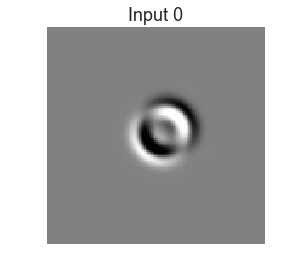

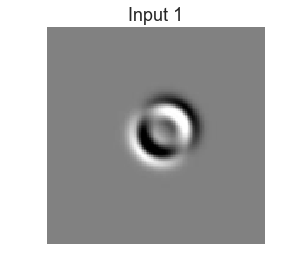

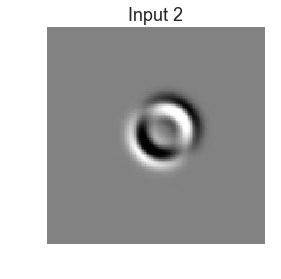

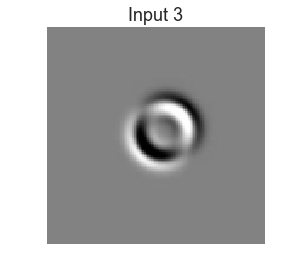

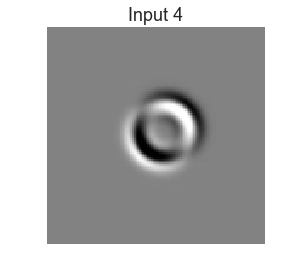

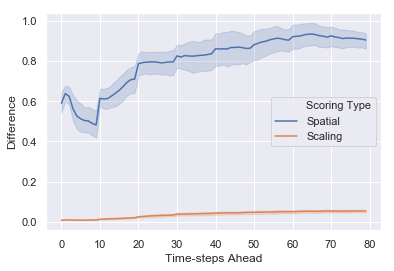

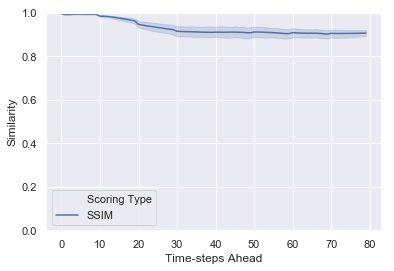

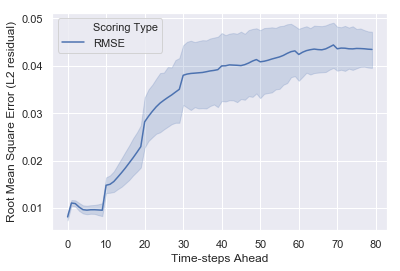

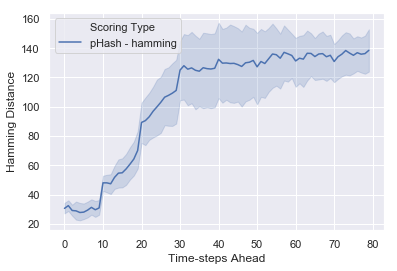

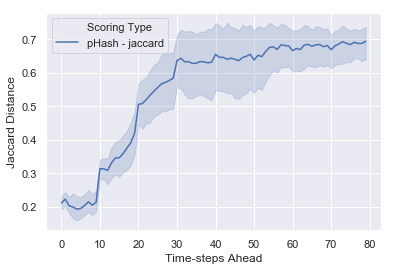

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.io import figure_save
import random
import math
import numpy as np
from PIL import Image
from utils.io import imshow

plot=False

def initial_input(No_more_Target):
    output = model(ImageSeries.to(device))
    try:
        target = OriginalSeries[:, (t0 + cnt + num_input_frames) * channels:(t0 + cnt + num_input_frames + 1) * channels, :, :].to(device)
    except:
        No_more_Target = True
        target = None
    return output, target, No_more_Target

def reinsert(output, target, No_more_Target):
    output = torch.cat((output, model(ImageSeries, mode="reinsert")), dim=1)
    try:
        target = torch.cat(
            (target, OriginalSeries[:, (t0 + cnt + num_input_frames) * channels:(t0 + cnt + num_input_frames + 1) * channels, :, :].to(device)
             ), dim=1)
    except:
        No_more_Target = True
    return output, target, No_more_Target

def propagate(output, target, No_more_Target):
    if n < (num_output_frames - refeed_offset):
        output = torch.cat((output, model(torch.Tensor([0]), mode="propagate")), dim=1)
        try:
            target = torch.cat(
                (target, OriginalSeries[:, (t0 + cnt + num_input_frames) * channels:(t0 + cnt + num_input_frames + 1) * channels, :, :].to(device)
            ), dim=1)
        except:
            No_more_Target = True
    return output, target, No_more_Target

def plot_predictions():
    if (total == 0) & (n == 0) & (run == 0):
        for imag in range(int(ImageSeries.shape[1] / channels)):
            fig = plt.figure().add_axes()
            sns.set(style="white")  # darkgrid, whitegrid, dark, white, and ticks
            sns.set_context("talk")
            imshow(ImageSeries[selected_batch, imag * channels:(imag + 1) * channels, :, :], title="Input %01d" % imag, obj=fig)
            figure_save(results_dir + "Input %02d" % imag)
    if (total == 0) & (n < (num_output_frames - refeed_offset)):
        predicted = output[selected_batch, -channels:, :, :].cpu()
        des_target = target[selected_batch, -channels:, :, :].cpu()
        fig = plt.figure()
        sns.set(style="white")  # darkgrid, whitegrid, dark, white, and ticks
        sns.set_context("talk")
        pred = fig.add_subplot(1, 2, 1)
        imshow(predicted, title="Predicted %02d" % cnt, smoothen=True, obj=pred)
        tar = fig.add_subplot(1, 2, 2)
        imshow(des_target, title="Target %02d" % target_cnt, obj=tar)
        figure_save(results_dir + "Prediction %02d" % cnt)
        plt.show() if plot else plt.close()

def plot_cutthrough(frequently_plot=5, direction="Horizontal", location=None):
    def cutthrough(img1, img2,  hue1, hue2):
        intensity = []
        location = []
        hue = []
        if "Horizontal" in direction:
            intensity = np.append(img1[stdmax[0],:], img2[stdmax[0],:])
            length1 = img1.shape[1]
            length2 = img2.shape[1]
            location = list(range(length1)) + list(range(length2))
            hue = [hue1] * length1 + [hue2] * length2
        elif "Vertical" in direction:
            intensity = np.append(img1[:,stdmax[0]], img2[:,stdmax[0]])
            width1 = img1.shape[0]
            width2 = img2.shape[0]
            location = list(range(width1)) + list(range(width2))
            hue = [hue1] * width1 + [hue2] * width2

        data_dict = {"Intensity": intensity, "Pixel Location": location, "Image": hue}
        #g = sns.FacetGrid(pd.DataFrame.from_dict(data_dict), col="Image")
        #g.map(sns.lineplot, "Pixel Location", "Intensity")
        sns.lineplot(x="Pixel Location", y="Intensity", hue="Image",
                     data=pd.DataFrame.from_dict(data_dict), ax=profile)
        profile.set_title("Intensity Profile")

    if total == 0:
        if ((cnt + 1) % frequently_plot) == 0 or (cnt == 0):
            predicted = output[selected_batch, -channels:, :, :].cpu()
            des_target = target[selected_batch, -channels:, :, :].cpu()
            fig = plt.figure()
            sns.set(style="white")  # darkgrid, whitegrid, dark, white, and ticks
            with sns.axes_style("white"):
                pre = fig.add_subplot(2, 2, 1)
                tar = fig.add_subplot(2, 2, 2)
            with sns.axes_style("darkgrid"):  # darkgrid, whitegrid, dark, white, and ticks
                profile = fig.add_subplot(2, 2, (3, 4))

            predicted = imshow(predicted, title="Predicted %02d" % cnt, return_np=True, obj=pre)
            des_target = imshow(des_target, title="Target %02d" % target_cnt, return_np=True, obj=tar)
            if not location:
                if "Horizontal" in direction:
                    std = np.std(des_target, axis=1)
                elif "Vertical" in direction:
                    std = np.std(des_target, axis=0)
                stdmax = np.where(std.max() == std)
            else:
                stdmax = location

            if "Horizontal" in direction:
                pre.plot([0, np.shape(std)[0]], [stdmax[0], stdmax[0]], color="yellow")
                tar.plot([0, np.shape(std)[0]], [stdmax[0], stdmax[0]], color="yellow")
            elif "Vertical" in direction:
                pre.plot([stdmax[0], stdmax[0]], [0, np.shape(std)[0]], color="yellow")
                tar.plot([stdmax[0], stdmax[0]], [0, np.shape(std)[0]], color="yellow")

            cutthrough(predicted, des_target, "Predicted", "Target")
            figure_save(results_dir + "Cut-through %02d" % cnt, obj=fig)
            plt.show() if plot else plt.close()




def add_score(score_keeper, output, target, num_output_frames, channels, cnt, No_more_Target):
    if (not No_more_Target) & (n < (num_output_frames - refeed_offset)):
        for ba in range(output.size()[0]):
            score_keeper.add(output[ba, -channels:, :, :].cpu(), 
                             target[ba, -channels:, :, :].cpu(), 
                             cnt,"pHash", "pHash2", "SSIM", "Own", "RMSE")

def introduce(prev_data):
    """
    If you want to introduce new droplets live during simulation
    NOT USED
    """
    def find_mean(input_img):
        for k in range(int(input_img.size()[0])):
            mean, number = np.unique(input_img[k:k + 1, :, :], return_counts=True)
            mean = np.full(np.shape(input_img[k:k + 1, :, :]), mean[np.argmax(number)])
            mean = torch.Tensor([mean])
            if k == 0:
                matrix = mean
            else:
                matrix = torch.cat((matrix, mean), dim=1)
        return matrix.squeeze_(0)

    prev_data = prev_data.cpu()
    data = My_Test[0]["image"][t0 * channels: (t0 + num_input_frames) * channels, :, :]
    for i in range(int(data.size()[0] / channels)):
        means = find_mean(data[i * channels:(i + 1) * channels, :, :])
        prev_data[selected_batch, i * channels:(i + 1) * channels, :, :] += data[i * channels:(i + 1) * channels, :, :] - means
    return prev_data


model.eval()
correct = total = 0
t0 = 15 # Can be 0
refeed_offset = 0
selected_batch = random.randint(0, 15)
if (num_output_frames - refeed_offset) < num_input_frames:
    refeed_offset = num_output_frames - num_input_frames
for batch_num, batch in enumerate(test_dataloader):
    OriginalSeries = batch["image"]
    ImageSeries = OriginalSeries[:, t0 * channels:(t0 + num_input_frames) * channels, :, :]
    model.reset_hidden(ImageSeries.size()[0])
    No_more_Target = False
    cnt = target_cnt = 0
    for run in range(int(math.ceil((100 - (t0 + num_input_frames + 1)) / (num_output_frames - refeed_offset)))):
        if run != 0:
            if (refeed_offset == 0) or ((num_output_frames - refeed_offset) <= num_input_frames):
                ImageSeries = output[:, -num_input_frames * channels:, :, :]
            else:
                ImageSeries = output[:, -(num_input_frames + refeed_offset) * channels:-refeed_offset * channels, :, :]
            cnt -= refeed_offset
        for n in range(num_output_frames):
            if n == 0:
                if run == 0:
                    output, target, No_more_Target = initial_input(No_more_Target)
                else:
                    output, target, No_more_Target = reinsert(output, target, No_more_Target)
            else:
                output, target, No_more_Target = propagate(output, target, No_more_Target)
                # output & target size is [batches, channels * (n + 1), 128, 128]

            add_score(score_keeper, output, target, num_output_frames, channels, cnt, No_more_Target)
            plot_predictions()
            plot_cutthrough()
            cnt += 1
            if not No_more_Target:
                target_cnt = copy.copy(cnt)

    total += target.size()[0]
    logging.info("{:d} out of {:d}".format(batch_num + 1, len(test_dataloader)))
    break
logging.info("Correct: {}\tPercentile: {:.0f}%".format(correct, 100 * correct / total))
score_keeper.plot(results_dir)